# SmartEnergy – EDA & Prototype

Ce notebook charge les CSV déposés dans MinIO, fait une EDA rapide,
extrait des features temporelles et entraîne un premier modèle (régression) pour la consommation.


In [1]:
import os, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from minio import Minio
from dotenv import load_dotenv

In [2]:
# -------------------------------
# Connexion à MinIO
# -------------------------------
load_dotenv('.env')
ENDPOINT = os.getenv('MINIO_ENDPOINT', 'localhost:9000')
ACCESS_KEY = os.getenv('MINIO_ACCESS_KEY', 'minioadmin')
SECRET_KEY = os.getenv('MINIO_SECRET_KEY', 'minioadmin')
SECURE = os.getenv('MINIO_SECURE', 'false').lower() == 'true'
BUCKET = os.getenv('MINIO_BUCKET', 'smartcity-energy')
PREFIX = os.getenv('MINIO_PREFIX', 'raw/')

client = Minio(ENDPOINT, access_key=ACCESS_KEY, secret_key=SECRET_KEY, secure=SECURE)
print("Connexion MinIO OK →", ENDPOINT)

Connexion MinIO OK → localhost:9000


In [3]:
# -------------------------------
# Lister les objets disponibles
# -------------------------------
objects = list(client.list_objects(BUCKET, prefix=PREFIX, recursive=True))
for o in objects:
    print('📁', o.object_name)

📁 raw/enedis_conso_journaliere_categorie_last6m.csv
📁 raw/odre_consommation_quotidienne_elec_last8w.csv
📁 raw/rte_eco2mix_national_tr_last30d.csv


In [4]:
# -------------------------------
# Fonction utilitaire : lire un CSV depuis MinIO
# -------------------------------
def read_csv_from_minio(bucket, key, sep=','):
    response = client.get_object(bucket, key)
    try:
        data = response.read()
        # détecte le séparateur
        sample = data[:500].decode('utf-8', errors='ignore')
        if ';' in sample and ',' not in sample.split('\n')[0]:
            sep = ';'
        return pd.read_csv(io.BytesIO(data), sep=sep)
    finally:
        response.close()
        response.release_conn()

In [5]:
# -------------------------------
# Chargement des 3 datasets
# -------------------------------
rte_key = PREFIX + 'rte_eco2mix_national_tr_last30d.csv'
odre_key = PREFIX + 'odre_consommation_quotidienne_elec_last8w.csv'
enedis_key = PREFIX + 'enedis_conso_journaliere_categorie_last6m.csv'

dfs = {}
for name, key in [('rte', rte_key), ('odre', odre_key), ('enedis', enedis_key)]:
    try:
        dfs[name] = read_csv_from_minio(BUCKET, key)
        print(f"✅ {name} chargé :", dfs[name].shape)
    except Exception as e:
        print(f"⚠️ {name} erreur :", e)

✅ rte chargé : (2881, 42)
✅ odre chargé : (239616, 12)
✅ enedis chargé : (32868, 3)


In [6]:
# -------------------------------
# Préparation du dataset RTE
# -------------------------------
df = dfs['rte'].copy()
df.columns = (df.columns.str.strip()
              .str.lower()
              .str.replace(" - ", "_")
              .str.replace("-", "_")
              .str.replace(" ", "_"))
print("Colonnes RTE :", df.columns[:10].tolist())

# repère la colonne date et consommation
time_col = 'date_heure_std' if 'date_heure_std' in df.columns else [c for c in df.columns if 'date' in c and 'heure' in c][0]
target_col = [c for c in df.columns if 'consommation' in c][0]
print("time_col =", time_col, "| target_col =", target_col)

Colonnes RTE : ['périmètre', 'nature', 'date', 'heure', 'date_heure', 'consommation_(mw)', 'prévision_j_1_(mw)', 'prévision_j_(mw)', 'fioul_(mw)', 'charbon_(mw)']
time_col = date_heure_std | target_col = consommation_(mw)


In [7]:
# conversion datetime
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col, target_col])
df = df.sort_values(time_col)

In [9]:
# -------------------------------
# Feature engineering simple
# -------------------------------
df['hour'] = df[time_col].dt.hour
df['dow'] = df[time_col].dt.dayofweek
df['is_weekend'] = df['dow'].isin([5,6]).astype(int)

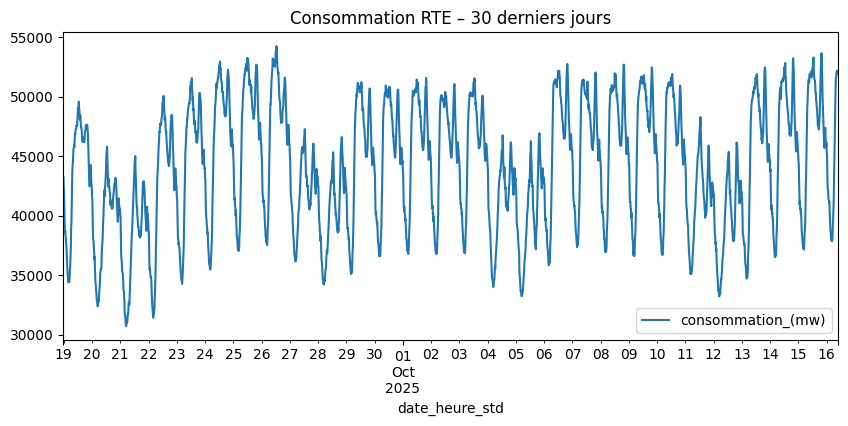

In [10]:
# -------------------------------
# Visualisation
# -------------------------------
df.plot(x=time_col, y=target_col, figsize=(10,4), title='Consommation RTE – 30 derniers jours')
plt.show()

📊 MAE = 940.8 | RMSE = 1130.3 | R² = 0.956


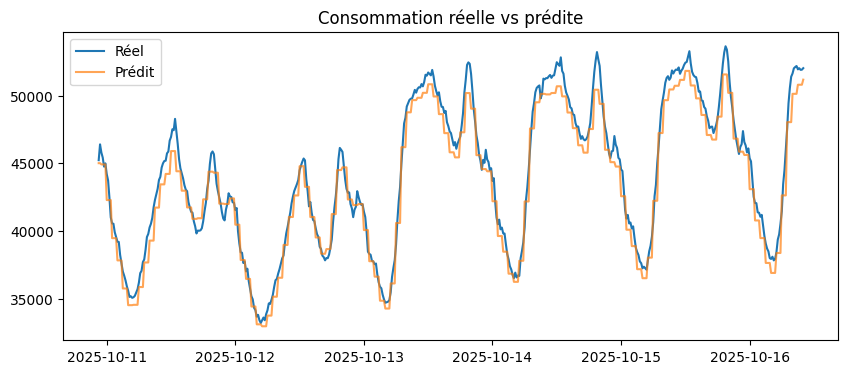

In [16]:
# -------------------------------
# Baseline modèle (RandomForest)
# -------------------------------
split = int(len(df)*0.8)
train, test = df.iloc[:split], df.iloc[split:]
feats = ['hour', 'dow', 'is_weekend']

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(train[feats], train[target_col])
pred = model.predict(test[feats])

mae = mean_absolute_error(test[target_col], pred)
rmse = np.sqrt(mean_squared_error(test[target_col], pred))
r2 = r2_score(test[target_col], pred)

print(f"📊 MAE = {mae:.1f} | RMSE = {rmse:.1f} | R² = {r2:.3f}")

# Visualisation
plt.figure(figsize=(10,4))
plt.plot(test[time_col], test[target_col], label='Réel')
plt.plot(test[time_col], pred, label='Prédit', alpha=0.7)
plt.title('Consommation réelle vs prédite')
plt.legend()
plt.show()


In [12]:
# -------------------------------
# Sauvegarde du modèle dans MinIO
# -------------------------------
from joblib import dump
from io import BytesIO
buf = BytesIO()
dump(model, buf)
buf.seek(0)

models_prefix = PREFIX.replace('raw/','models/')
client.put_object(BUCKET, models_prefix + "rf_baseline.joblib",
                  buf, length=len(buf.getvalue()),
                  content_type="application/octet-stream")
print("✅ Modèle sauvegardé :", models_prefix + "rf_baseline.joblib")

✅ Modèle sauvegardé : models/rf_baseline.joblib


C:\Users\baliz\AppData\Local\Temp\ipykernel_12864\2950521187.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_idx = pd.date_range(last_ts + pd.Timedelta(minutes=15), periods=96, freq="15T")


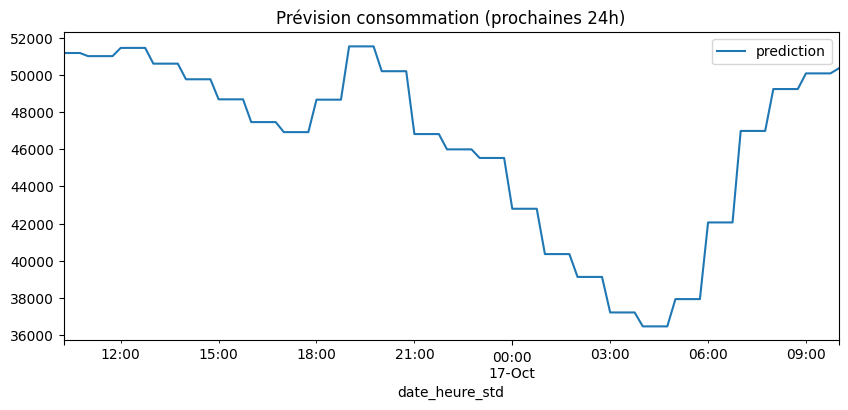

In [13]:
# -------------------------------
# Prévision 24h (pas 15 min)
# -------------------------------
last_ts = df[time_col].max()
future_idx = pd.date_range(last_ts + pd.Timedelta(minutes=15), periods=96, freq="15T")
fut = pd.DataFrame({time_col: future_idx})
fut['hour'] = fut[time_col].dt.hour
fut['dow'] = fut[time_col].dt.dayofweek
fut['is_weekend'] = fut['dow'].isin([5,6]).astype(int)
fut['prediction'] = model.predict(fut[feats])

fut.plot(x=time_col, y='prediction', figsize=(10,4), title='Prévision consommation (prochaines 24h)')
plt.show()